# __01_Freyberg_Schur__Original__80'__ 

### 2-dimensional 40 rows, 20 columns - 2 stress periods (1º steady-state and a 5-year transient)
### the last stress period use 25% less recharge and 25% more pumping  =  future conditions for a forecast period

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import flopy
import pyemu

from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [2]:
org_d = os.path.join("..","Freyberg","extra_crispy")
tmp_d = os.path.join('a2')                                                           # New folder
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)

'a2'

In [3]:
model_ws = os.path.join("a2")
ml = flopy.modflow.Modflow.load("freyberg.nam", model_ws=tmp_d)

   could not parse xul in E:\15_REPOS\00_BETAMI\03_pyEMU\01_schur__ok\a2\freyberg.nam


In [4]:
sr = pyemu.helpers.SpatialReference.from_namfile( os.path.join(model_ws, ml.namefile),  delc=ml.dis.delc, delr=ml.dis.delr)

ml.modelgrid.set_coord_info( xoff=sr.xll, yoff=sr.yll, angrot=sr.rotation, crs=sr.proj4_str, merge_coord_info=True)

## __Pause__

In [5]:
# pst.write(os.path.join(template_ws, 'a2.pst'),version=2)              # First time written          # Result, ... empty files !!!

# __schur__ __=__ __PREDUNC__ __=__ __COV__
<font color='blue'> __AIM=__ </font> forecast uncertainty and parameter uncertainty, ... so, [provide sensitivity vectors  IDs]

In [6]:
jco = os.path.join("freyberg.jcb")                 # ____________ *.jcb____  alredy on folder...(but let also creat it....)
pst = pyemu.Pst(jco.replace(".jcb",".pst"))                       # use the jco name with extension "pst" 
la = pyemu.Schur(jco=jco, pst=pst, verbose="schur_example.log")   # just log
print(la.forecast_names)

['or28c05_0', 'or28c05_1', 'sw_gw_0', 'sw_gw_1']


In [7]:
la.posterior_parameter.to_ascii(jco+"_post.cov")                  # BEST IF inside folder a2 ... not yet ...

In [8]:
# la.posterior_parameter.to_dataframe().sort_index().\
# sort_index(axis=1).iloc[0:5,0:5]                                # 761 x 761 PAR 

# __Plots__
#### After calibration, prior PAR & epistemic OBS cov. matrices `  ` __freyberg.jcb_post.cov__

<Axes: >

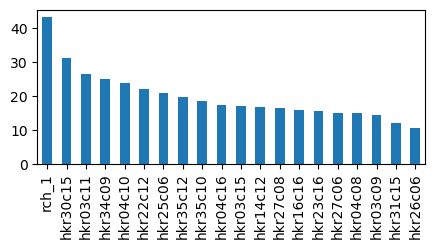

In [9]:
par_sum = la.get_parameter_summary().\
   sort_values("percent_reduction",ascending=False)
par_sum.loc[par_sum.index[:20],"percent_reduction"].\
   plot(kind="bar",figsize=(5,2),edgecolor="none")           # par_sum.iloc[0:5,:]               # diagonal __________________

Text(0.5, 1.0, 'Percent Reduction')

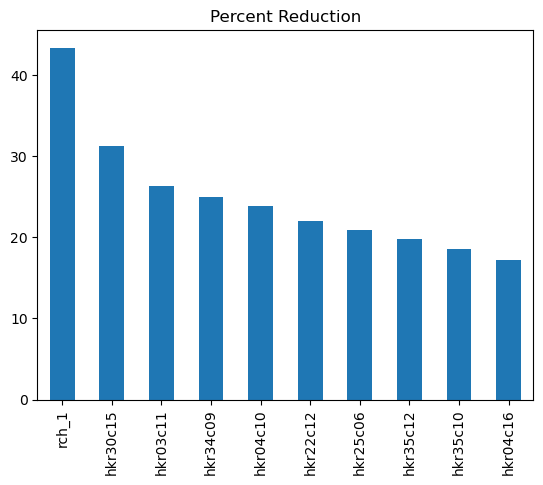

In [10]:
par_sum.iloc[0:10,:]['percent_reduction'].plot(kind='bar')          # uncertainty reductions
plt.title('Percent Reduction')

<Axes: >

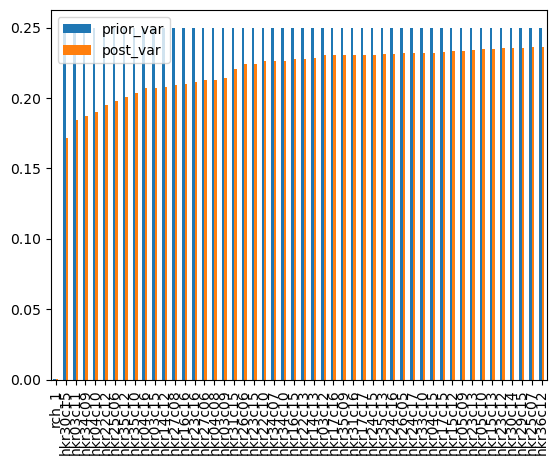

In [11]:
par_sum.iloc[0:50,:][['prior_var','post_var']].plot(kind='bar')  #  prior and posterior variance & % reductions

Calibration (12 Hs) reduces the uncertainty of `rch_0` by 43%. `  `K of many model cells is also reduced.  

In [12]:
# ml.modelgrid.extent, ml.modelgrid.xoffset, ml.modelgrid.xvertices # Map uncertainty reduction for the hydraulic conductivity PAR 

C:\Users\gross.DESKTOP-AIRQM2M\AppData\Local\Temp\ipykernel_13024\2246065046.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


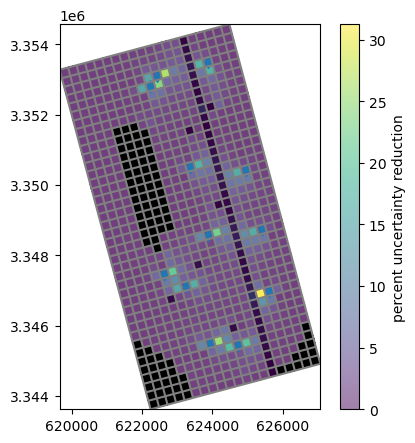

In [16]:
# ml = flopy.modflow.Modflow.load("freyberg.nam", model_ws=tmp_d)
# sr = pyemu.helpers.SpatialReference.from_namfile(os.path.join(model_ws, ml.namefile),  delc=ml.dis.delc, delr=ml.dis.delr)

hk_pars = par_sum.loc[par_sum.groupby(lambda x:"hk" in x).groups[True],:]
hk_pars.loc[:,"names"] = hk_pars.index
names = hk_pars.names
hk_pars.loc[:,"i"] = names.apply(lambda x: int(x[3:5]))             # use the parameter names to parse out row and column locations
hk_pars.loc[:,"j"] = names.apply(lambda x: int(x[6:8]))             # set up an array of the value -1 the same shape 
unc_array = np.zeros_like(ml.upw.hk[0].array) - 1                   # as the HK array in the UPW package
for i,j,unc in zip(hk_pars.i,hk_pars.j,hk_pars.percent_reduction):  # fill the array with percent reduction values
    unc_array[i,j] = unc 

# setting the array values that are still -1 (e.g. no percent reduction value in the cell) to np.NaN so that they don't get displayed on the plot
unc_array[unc_array == -1] = np.nan
extent=ml.modelgrid.extent                  # plot some model attributes

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111,aspect="equal")

ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])
obs = pd.read_csv(os.path.join("..", "Freyberg","misc","obs_rowcol.dat"), delim_whitespace=True) # plot obs locations
obs_x = [ml.modelgrid.xcellcenters[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.modelgrid.ycellcenters[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]

modelmap = flopy.plot.PlotMapView(model=ml)
modelmap.plot_grid()

cb = modelmap.plot_array(unc_array, alpha=0.5)
plt.colorbar(cb,label="percent uncertainty reduction")
ax.scatter(obs_x,obs_y,marker='d')                        # plt.savefig("par_unc_map.pdf")

# __Forecast_uncertainty__
Now let's examine the prior and posterior variance of the forecasts. The uncertainty in parameters directly impacts the uncertainty of forecasts made with the model. Four forecasts were identified for analysis, as described above:

1. `sw_gw_0`: the surface water/groundwater exchange during the calibration stress period
2. `sw_gw_1`: the surface water/groundwater exchange during the prediction stress period
3. `or28c05_0`: the head in well cell 6 (row 28, column 5) at the end of the calibration stress period
4. `or28c05_1`: the head in well cell 6 (row 28, column 5) at the end of the prediction stress period


,prior_var,post_var,percent_reduction
or28c05_0,0.401023,0.106080,73.547647
or28c05_1,0.773414,0.666633,13.806425
sw_gw_0,79634.034592,50438.518215,36.662109
sw_gw_1,111548.355615,110972.261543,0.516452


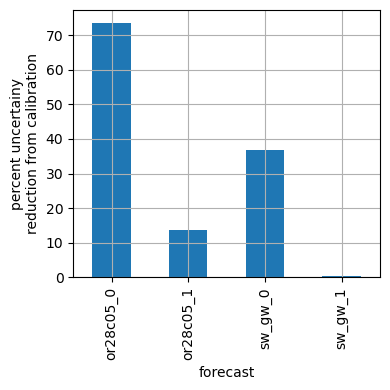

In [17]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax = la.get_forecast_summary().percent_reduction.plot(kind='bar',
                                                      ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()
plt.savefig("forecast_sum.pdf")
la.get_forecast_summary()

Notice the spread on the uncertainty reduction: some forecasts benefit more from calibration than others.  For example, ```or28c05_0```, the calibration-period water level forecast, benefits from calibration since its uncertainty is reduced by about 75%, while ```sw_gw_1```, the forecast-period surface-water groundwater exchange forecast does not benefit from calibration - its uncertainty is unchanged by calibration



## Parameter contribution to forecast uncertainty

### Overview
As we observed above, information cascades from observations to parameters and then out to forecasts. With specific forecasts of interest, we can evaluate which information contributes most to forecast uncertainty. This is accomplished by assuming a parameter (or group of parameters) is perfectly known and assessing the forecast uncertainty under that assumption. Of course, this is a pretty serious approximation because perfect knowledge of a parameter can never be obtained in reality. In fact, it is difficult to calculate what, for example, a pumping test will provide in terms of uncertainty reduction for a parameter. Nonetheless, this metric can still provide important insights into model dynamics and help guide future data collection efforts.

### Evaluating parameters by groups
With the Freyberg example, we can evaluate parameter contributions to forecast uncertainty with groups of parameters by type. 

In [ ]:
df = la.get_par_group_contribution()
df

In [ ]:
#calc the percent reduction in posterior
df_percent = 100.0 * (df.loc["base",:]-df)/\
                      df.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
ax = df_percent.T.plot(kind="bar", ylim=[0,100],figsize=(8,5))
ax.grid()
plt.tight_layout()
plt.savefig('indiv_pars_certain_future.pdf')



We see some interesting results here.  The sw-gw flux during calibration (```sw_gw_0```) is influenced by both recharge and hk uncertainty, but the forecast period sw-gw flux is influenced most by recharge uncertainty. For the water level forecasts (```or28c05_0 and or28c05_1```), the results are similar: the forecast of water level at the end of the calibration period benefits most from hk knowledge, while the forecast period water level is most informed by recharge and storage. 

As expected, in both cases `rcond` has no impact on forecast uncertainty (typically, river conductance is insensitive and noninfluential across a wide range of values) and `storage` plays no role in the steady-state calibration period but is important for the transient forecast period. Uncertainty in `welflux` plays a small role but is eclipsed by `rch` which is responsible for a much more substantial amount of flux.

### Evaluating an alternative grouping 
Let's repeat the analysis, but now group the parameters differently:

The forcings in the model are the well pumping rates (`welflux`) and recharge (`rch`). The suffix `_1` indicates the calibration period while `_2` indicates the forecast period. Based on this, we can create two groupings for the forcings in the two periods. Other parameters (hydraulic conductivity, storage, and river conductance) are relegated to a third group of properties.

If we create a dictionary identifying groups as keys with lists of parameter names as values, we can pass that to the `get_par_contribution()` method. The dataframe returned will group results by the keys of the dictionary.

In [ ]:
pnames = la.pst.par_names
fore_names = [pname for pname in pnames if pname.endswith("_2")]
props = [pname for pname in pnames if pname[:2] in ["hk","ss","sy","rc"] and\
         "rch" not in pname]
cal_names = [pname for pname in pnames if pname.endswith("_1")]
pdict = {'forecast forcing':fore_names,"properties":props,
         "calibration forcing":cal_names}
df = la.get_par_contribution(pdict)

In [ ]:
#calc the percent reduction in posterior
df_percent_alt = 100.0 * (df.loc["base",:]-df)/\
                          df.loc["base",:]
#drop the base column
df_percent_alt = df_percent_alt.iloc[1:,:]
df_percent_alt

In [ ]:
#transpose and plot
df_percent_alt.T.plot(kind="bar", ylim=[0, 100], figsize=(8,5))
plt.tight_layout()
plt.grid()
plt.savefig('certain_future.pdf')

In [ ]:
df_percent_alt

These results are also intuitive. For both forecasts originating from the second model stress period (the "forecast" period), the forecast-period forcings (which represent future recharge and future water use) play a role in reducing forecast uncertainty for the forecast period. Calibration forcings (current recharge and water use) are important for the calibration-period `sw_gw` exchange forecast (``sw_gw_0``), but are dwarfed by properties for the calibration-period head forecast (``or28c05_0``). Properties are important across the board, but in both cases their importance is reduced in the forecast period due to the increasing importance of forcing.

Evaluation of these dynamics is useful to understand the dynamics of the model, but it is difficult to quantify just how uncertainty can be reduced directly on parameters. On the other hand, we know that observations provide information on parameters through the calibration process. In a sense it is more straightforward to quantify how observation information impacts forecast uncertainty, so we can explore the worth of observation data.

# Data worth analysis

## Overview
Data worth can be broken into two main categories: the worth of data pertaining directly to parameters, and the data pertaining to observations.

There are two main applications of data worth analysis. One is to evaluate the worth of observations in an existing network of observations, and the other is to evaluate the value of potential new observations. 

## Data worth--evaluating the value of existing observations
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases

```get_removed_obs_group_importance()``` is a thin wrapper that calls the underlying ```get_removed_obs_importance()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  This method tests how important non-zero weight observations are for reducing forecast uncertainty. The metric provided is the forecast uncertainty that can be attributed to each observation group. 

This call will test all of the non-forecast, non-zero weight observations in the PEST data set to see which ones are most important. 


In [ ]:
df_worth = la.get_removed_obs_importance()
df_worth

The ```base``` row contains the results of the Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for each of the 12 water level observations (e.g. or17c17 is the observation in row 18 column 18) show how much forecast uncertainty increases when that particular observation is not used in history matching.  So we see again that each forecast depends on the observations differently.

We can normalize the importance to the maximum importance value to create a metric of data worth which will be between 0 and 100%. Then we can also determine which observation has the highest data worth with respect to each forecast and also report how much reduction in uncertainty it is responsible for (e.g. how much does forecast uncertainty increase if that data point is not used for history matching)



In [ ]:
# a little processing of df_worth
df_base = df_worth.loc["base",:].copy()
df_imax = df_worth.apply(lambda x:x-df_base,axis=1).idxmax()
df_max = 100.0 * (df_worth.apply(lambda x:x-df_base,axis=1).max() / df_base)
df_par = pd.DataFrame([df_imax,df_max],
                      index=["most important observation",
                             "percent increase when left out"])
df_par

We see that observation ```or27c07_0``` is the most important for the water level forecasts (```or28c05_0``` and ```or28c05_1```), while observation ```or10c02_0``` is the most important for the surface water groundwater exchange forecasts (```sw_gw_0``` and ```sw_gw_1```). Also, observation ```or10c02_0```) results in a much greater increase in uncertainty for forecast ```sw_gw_0``` than it does for ```sw_gw_1```.

## Data worth--evaluating the potential value of new observations
A potential water-level observation for each active model cell was also "carried" in the PEST control file.  This means we can run this same analysis to find the best next place to collect a new water level.  This takes a little longer because it is rerunning the schur's complement calculations many times, so this section can be skipped.

### Define the potential observation locations
First we need a list of the observations with zero weight and that start with `"or"`--- (these are the synthetic proposed locations)

In [ ]:
pst.observation_data.index = pst.observation_data.obsnme
new_obs_list = [n for n in pst.observation_data.obsnme.tolist() if n not in la.forecast_names \
                and n not in la.pst.nnz_obs_names]
print ("number of potential new obs locations:",len(new_obs_list))

This takes a while since we are evaluating forecast uncertainty for each of the potential obs locations...

In [ ]:
from datetime import datetime
start = datetime.now()
df_worth_new_0= la.get_added_obs_importance(base_obslist=la.pst.nnz_obs_names,
                            obslist_dict=new_obs_list,reset_zero_weight=1.0)
print("took:",datetime.now() - start)

In [ ]:
df_worth_new_0.head()

Similar to the value of existing data, these results are specific to the forecast of interest. However, when adding potential new observation data, we are looking at how uncertainty will _decrease_ if a proposed observation is _added_  to the 12 water level observations already being used for calibration(this is opposite of looking for the _increase_ in forecast uncertainty if an existing observation is _removed_). 

For each forecast, we can first determine which proposed new observation is most valuable.

### Make a function to postprocess the new data worth

In [ ]:
def postproc_newworth(df_worth_new):
    # a little processing of df_worth
    df_new_base = df_worth_new.loc["base",:].copy()
    df_new_imax = df_worth_new.apply(lambda x:df_base-x,axis=1).idxmax()
    df_new_worth = 100.0 * (df_worth_new.apply(lambda x:df_base-x,axis=1) /\
                            df_new_base)
    df_new_max = df_new_worth.max()
    df_par_new = pd.DataFrame([df_new_imax,df_new_max],
                              index=["most important observation",
                                     "percent decrease when added"])
    df_par_new

    df_new_base1 = df_worth_new.loc["base",:].copy()
    df_new_imax1 = df_worth_new.apply(lambda x:df_new_base1-x,axis=1).\
                                      idxmax()
    df_new_worth1 = 100.0 * (df_worth_new.apply(
            lambda x:df_new_base1-x,axis=1) / df_new_base1)

    df_new_worth_plot1 = df_new_worth1[df_new_worth1.index != 'base'].copy()
    df_new_worth_plot1.loc[:,'names'] = df_new_worth_plot1.index
    names = df_new_worth_plot1.names
    df_new_worth_plot1.loc[:,"i"] = names.apply(lambda x: int(x[2:4]))
    df_new_worth_plot1.loc[:,"j"] = names.apply(lambda x: int(x[5:7]))
    df_new_worth_plot1.loc[:,'SP'] = names.apply(lambda x: int(x[-1]))
    df_new_worth_plot1.head()
    return df_new_worth_plot1, df_par_new

In [ ]:
df_new_worth_plot_0, df_par_new_0 = postproc_newworth(df_worth_new_0)
df_par_new_0

### Make a function that can display data worth for added observations


In [ ]:
def plot_added_importance(df_worth_plot, ml, forecast_name=None, 
                          newlox = None,figsize=(20,15)):

    vmax = df_worth_plot[forecast_name].max()
    
    #fig = plt.figure(figsize=(20,15))
    fig = plt.figure(figsize=figsize)
    axlist = []
    # if new locations provided, plot them with their numbers
    if newlox:
        currx = []
        curry = []
        for i,clox in enumerate(newlox):
            crow = int(clox[2:4])
            ccol = int(clox[5:7])
            currx.append(ml.modelgrid.xcellcenters[crow,ccol])
            curry.append(ml.modelgrid.ycellcenters[crow,ccol])

    
    for SP in range(1):
        
        unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
        df_worth_csp = df_worth_plot.groupby('SP').get_group(SP)
        for i,j,unc in zip(df_worth_csp.i,df_worth_csp.j,
                           df_worth_csp[forecast_name]):
            unc_array[i,j] = unc 
        unc_array[unc_array == -1] = np.nan
        axlist.append(plt.subplot(111,aspect="equal"))
#         cb = axlist[-1].imshow(unc_array,interpolation="nearest",
#                                alpha=0.5,extent=ml.modelgrid.extent, 
#                                vmin=0, vmax=vmax)
        ml.riv.stress_period_data.plot(axes=[axlist[-1]])

        # plot obs locations
        obs = pd.read_csv(os.path.join("Freyberg","misc","obs_rowcol.dat"),
                          delim_whitespace=True)
        obs_x = [ml.modelgrid.xcellcenters[r-1,c-1] for r,c \
                 in obs.loc[:,["row","col"]].values]
        obs_y = [ml.modelgrid.ycellcenters[r-1,c-1] for r,c \
                 in obs.loc[:,["row","col"]].values]
        axlist[-1].scatter(obs_x,obs_y,marker='d')

        # add the heads
        headsp = int(forecast_name[-1])
        kstpkper = (0,headsp)
        fname = os.path.join(ml.model_ws,'freyberg.hds')
        hdobj = flopy.utils.HeadFile(fname)
        head = hdobj.get_data(kstpkper=kstpkper)
        levels = np.arange(10, 30, .5)
        modelmap = flopy.plot.PlotMapView(model=ml)
        cb = modelmap.plot_array(unc_array, alpha=0.5, vmin=0, vmax=vmax)
        contour_set = modelmap.contour_array(head, masked_values=[999.], 
                                             levels=levels,axes=axlist[-1])
        if SP==0:
            plt.colorbar(cb,label="percent uncertainty reduction")

        # plot the pumping wells
        ml.wel.stress_period_data.plot(axes=axlist[-1],color='k')
        
        # add discharge vectors
        fname = os.path.join(ml.model_ws, 'freyberg.cbc')
        cbb = flopy.utils.CellBudgetFile(fname)
        frf = cbb.get_data(kstpkper=kstpkper, text='FLOW RIGHT FACE')[0]
        fff = cbb.get_data(kstpkper=kstpkper, text='FLOW FRONT FACE')[0]
        #quiver = modelmap.plot_discharge(frf, fff, head=head, axes=axlist[-1])
        linecollection = modelmap.plot_grid(axes=axlist[-1])

        if newlox:
            for i,(cx,cy,cobs) in enumerate(zip(currx, curry, newlox)):
                csp = int(cobs[-1])
                if csp == SP:
                    axlist[-1].plot(cx, cy, 'rd', mfc=None, ms=18, alpha=0.8)
                    axlist[-1].text(cx-50,cy-50,i, size='medium')
                
        # finally, plot the location of the forecast if possible
        if forecast_name.startswith('or'):
            i = int(forecast_name[2:4])
            j = int(forecast_name[5:7])
            forecast_x = ml.modelgrid.xcellcenters[i,j]
            forecast_y = ml.modelgrid.ycellcenters[i,j]
            axlist[-1].scatter(forecast_x, forecast_y, marker='o', s=600, 
                               alpha=0.5)
            axlist[-1].scatter(forecast_x, forecast_y, marker='x', s=600)

        plt.title('Added Data Worth for {0}'.format(forecast_name))
    return fig

### We can look at the results for each forecast and for each stress period

In [ ]:
fig0 = plot_added_importance(df_new_worth_plot_0, ml, 'or28c05_0')

In [ ]:
fig1 = plot_added_importance(df_new_worth_plot_0, ml, 'or28c05_1')

In [ ]:
fig2 = plot_added_importance(df_new_worth_plot_0, ml, 'sw_gw_0')

In [ ]:
fig3 = plot_added_importance(df_new_worth_plot_0, ml, 'sw_gw_1')